<font color='blue'> **MF_SETUP** </font> E:\15_REPOS\02_Beta-Me\data\Nerversink\a01.yml

In [ ]:
import geopandas as gp ; import flopy as fp ; import mfsetup     ; import os ; import numpy as np ; import matplotlib.pyplot as plt ; import yaml ; import pyproj ; from pathlib import Path     
import pandas as pd ; import rasterio    ; from rasterio.plot import show ; import shutil              ; _R = Path('E:/15_REPOS/02_Beta-Me/mfsetup/01_nerversink/_R');_R.mkdir(exist_ok=True)
MFSETUP=Path("./_R/MFSETUP");MFSETUP.mkdir(exist_ok=True)                       ; PP = Path('E:/15_REPOS/02_Beta-Me/data/Nerversink')   ; Domain = Path(PP/'Domain') ; Water=Path(PP/'Water')
PB_LITO = Path("E:/15_REPOS/02_Beta-Me/mfsetup/01_nerversink/_R/PB_LITO")       ; PB_LITO.mkdir(exist_ok=True)

In [2]:
domain = gp.read_file(Domain/'Model_Extent_HUC12.shp')                                                                  ; epsg = pyproj.CRS(domain.crs).to_epsg() 
bounds = domain.geometry[0].bounds                 ; TX,TY = bounds[2]+1000-bounds[0]  ,bounds[3]+1000-bounds[1]         
dx = 50 ; dy = dx   ; xcells = int(np.ceil(TX/dx)) ; ycells = int(np.ceil(TY/dy))                                       ; print(epsg,'Dimentions:',int(TX),int(TY), xcells*ycells)   

with open(PP/'a01.yml', 'r') as ifp:          IY = yaml.load(ifp, Loader=yaml.FullLoader)   # old___________________________________________  a01.yml
IY['setup_grid']['xoff'] = bounds[0]        ; IY['dis']['griddata']['delc']   = dx          ; IY['setup_grid']['yoff'] = bounds[1]       
IY['dis']['griddata']['delr'] = dy          ; IY['dis']['dimensions']['nlay'] = 1           ; IY['dis']['dimensions']['nrow'] = ycells      ; IY['dis']['dimensions']['ncol'] = xcells
with open(MFSETUP/'a02.yml', 'w') as ofp:           yaml.dump(IY, ofp)                          # new___________________________________________  a02.yml 

5070 Dimentions: 30908 33977 420920


<font color='orange'> **MFSETUP __________________________________________________** </font> <br>
<font color='orange'> **DIS __________________________________________________** </font> 

In [3]:
%%capture
m = mfsetup.MF6model.setup_from_yaml(MFSETUP/'a02.yml')        # YML _______________________________ 'E:/15_REPOS/02_Beta-Me/data/Nerversink/Domain/Model_Extent_HUC12.shp'          
m.dis.idomain.array.sum() * 5                              ; m.dis.export(Path("../PA_DIS")/'neverskink{}m.dis.shp'.format(dx))      # 1:30'

<font color='orange'> **WELLS __________________________________________________** </font> 

In [4]:
gdf = gp.read_file(Water/ 'wells_max_rates_and_ids.shp' )                            ; gdf.to_csv(_R/'_0.1_GWF.csv')
TA=Path("./Domain") ; domain = gp.read_file(Domain/'Model_Extent_HUC12.shp')        #; domain.geometry[0]
#fig, ax = plt.subplots() ; gdf.plot(ax=ax, markersize=10)                           ; domain.plot(ax=ax, facecolor='none', edgecolor='red') ; plt.show()

In [5]:
well_df = gdf.copy()
well_df   ['x'] = [coord.x for coord in gdf.geometry]  ; well_df['y'] = [coord.y for coord in gdf.geometry]
well_df.loc[(well_df.Stop_Meter == 0)       &   (well_df.Sbot_Meter == 0), 'Stop_Meter' ] =  2000
well_df.loc[(well_df.Stop_Meter == 2000)    &   (well_df.Sbot_Meter == 0), 'Sbot_Meter' ] = -2000            
well_df['flux_m3']=[i for i in well_df.Avg_Mgd*(-3785.41)] ; well_df['max_flux_m3']=[i for i in well_df.M_Rate_MGD*(-3785.41)]      ; well_df.to_csv(_R/'_0.1_well_df.csv')
well_df['start_datetime'] = '2009-01-01'    ; well_df['end_datetime'] = '2016-01-01'                                     ; well_df.drop(columns=['geometry'], inplace=True)
well_df.to_csv(_R/'_0.1_2009-2016_ave_pumping.csv')

<font color='orange'> **LITO __________________________________________________** </font> 

In [6]:
import pandas as pd
KZ=Path(PP/'Layers_and_Zones/K_ZONES')
KA = pd.read_excel(KZ/'Rondout_Neversink_GeologyLookupTable.xlsx'    ,sheet_name='Sheet2')  ; KA.index = KA.Lookup_Code
KB = pd.read_excel(KZ/'Rondout_Neversink_GeologyLookupTable_jhw.xlsx',sheet_name='Sheet2')  ; KB.index = KB.Lookup_Code

method = 'mean'
if method == 'mean':
    KB['Kh_ft_d_mean'] = (KB['Kh_ft_d_lower'] + KB['Kh_ft_d_upper']) / 2     ; KB['Kh_m_d'] = KB['Kh_ft_d_mean']  * 0.3048
if method == 'min':                                                            KB['Kh_m_d'] = KB['Kh_ft_d_lower'] * 0.3048
if method == 'max':                                                            KB['Kh_m_d'] = KB['Kh_ft_d_lower'] * 0.3048
if method == 'original':                                                       KB = KA.copy()
KB.to_csv(_R/'_0.2_KB.csv')
compare = KB.join(KA, rsuffix='_original')                                   ; compare = compare[['Geology_Type', 'Kh_m_d', 'Kh_m_d_original']]
compare['diff'] = compare['Kh_m_d'] - compare['Kh_m_d_original']             ; compare.to_csv(_R/'_0.2_compare.csv')

In [7]:
def zone2k(layer,KB,new_version=True):
    global KS
    if new_version:          KS = os.path.join(KZ/'L{}_K_Zone_50mGrid.tif')
    else:                    KS = os.path.join(KZ/'V2_Layer{}_K.tif')                                       
    with rasterio.open(KS.format(layer+1)) as src:
        crs = src.crs      ; ME = src.meta      ; NO = ME['nodata']   ; K_tuple = src.read(1, masked=True),   ; K_data = K_tuple[0].data.astype(float)    
    newK = K_data.copy()
    for idx in KB.index:     newK[newK==idx] = KB.loc[idx].Kh_m_d   
    newKv = newK / 10.0                                                                                ; OUTF = 'Layer{}_Kh.tif'.format(layer+1) ; OT1 = os.path.join(PB_LITO, OUTF)
    DA=rasterio.open(OT1,'w',driver=ME['driver'],height=newK.shape[0],width=newK.shape[1],count=1,nodata=NO,dtype=str(newK.dtype), crs=crs,compress='lzw',transform=ME['transform'])
    DA.write(newK, 1)       ; DA.close()                                                               ; OUTG = 'Layer{}_Kv.tif'.format(layer+1) ; OT2 = os.path.join(PB_LITO, OUTG)
    DA=rasterio.open(OT2,'w',driver=ME['driver'],height=newKv.shape[0],width=newKv.shape[1],count=1,nodata=NO/10.0,dtype=str(newKv.dtype),crs=crs,compress='lzw',transform=ME['transform'])
    DA.write(newKv,1)       ; DA.close()
for i in range(4):
    zone2k(i, KB)   #    print('now on layer {}'.format(i + 1))  ; 
shutil.copy(KZ/'Rondout_Neversink_GeologyLookupTable.xlsx',_R/'_0.2_GEO_01.xlsx')  ; shutil.copy(KZ/'Rondout_Neversink_GeologyLookupTable_jhw.xlsx',_R/'_0.2_GEO_02.xlsx')
KA.to_csv(_R/'_0.2_geo_03.csv') ; KB.to_csv(_R/'_0.2_geo_04.csv') #; KS

<font color='orange'> **LITO II __________________________________________________** </font> 

In [13]:
ZK=Path(PP/'Layers_and_Zones')
with rasterio.open(os.path.join(ZK/ 'L3_Bottom___TopOfBedrock.tif')) as src:
    crs=src.crs    ;meta=src.meta   ;nodata=meta['nodata']      ;L3T=src.read(1, masked=True),       ;L3D=L3T[0].data   ;L3M=L3T[0].mask     #;show(src)

In [9]:
L4D = np.where(L3D != nodata, L3D-33, L3D)      
dataset = rasterio.open(os.path.join(ZK, 'L4_Bottom.tif'),'w', driver=meta['driver'],height = L4D.shape[0], width = L4D.shape[1],count=1,nodata = nodata,dtype=str(L4D.dtype),
                        crs = crs,transform=meta['transform'],compress='lzw')                                                      ; dataset.write(L4D, 1)   ; dataset.close()

In [25]:
#I0  = np.ma.MaskedArray(L4D, L3M)  ; plt.imshow(I0) ; plt.colorbar()   ; plt.title('Layer 4 - Model Bottom') ; plt.show() # ______ Plot
#L3L4 = L3D-L4D  ;mL3L4=np.ma.MaskedArray(L3L4, L3M)  ; plt.imshow(L3L4) ; plt.colorbar() ; plt.tight_layout() ; plt.show() ; print('dif: {}'.format(list(np.unique(L3L4)))) # ______ Plot

In [21]:
TLO = os.path.join(ZK, 'top_50m_from_lidar.tif')   ; TL1 = os.path.join(ZK, 'L1_Bottom.tif')      ; TL2 = os.path.join(ZK, 'L2_Bottom.tif')
with rasterio.open(TLO) as src:    L0T = src.read(1, masked=True),     ; L0D = L0T[0].data        ; L0M = L0T[0].mask         ; L0ME = src.meta   #; show(src)         # L0ME
with rasterio.open(TL1) as src:    L1T = src.read(1, masked=True),     ; L1D = L1T[0].data        ; L1M = L1T[0].mask         ; L1ME = src.meta                         # L1ME
with rasterio.open(TL2) as src:    L2T = src.read(1, masked=True),     ; L2D = L2T[0].data        ; L2M = L2T[0].mask

L1L2  = L1D - L2D   ; ML1L2 = np.ma.MaskedArray(L1L2, L1M)      # plt.figure(figsize=(10,10)) ; plt.imshow(ML1L2) ; plt.colorbar()  ; plt.show()
L2L3  = L2D - L3D   ; ML2L3 = np.ma.MaskedArray(L2L3, L1M)      # plt.figure(figsize=(10,10)) ; plt.imshow(ML2L3) ; plt.colorbar() ; plt.show()
print('the minimum difference is: {:.05f} meters'.format(ML1L2.min()))  ;print('the minimum difference is: {:.05f} meters'.format(ML2L3.min()))

the minimum difference is: 0.99997 meters
the minimum difference is: 0.99997 meters


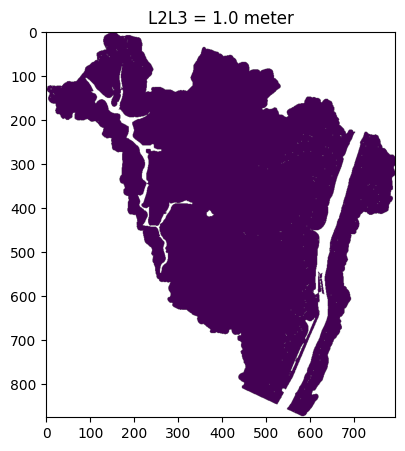

In [24]:
L1L2ISO = np.where((L1L2 == 1.), 1, np.nan)                  # plt.figure(figsize=(10,10)) ; plt.imshow(L1L2ISO)   ; plt.title(      'L1L2 = 1.0 meter')  ; plt.show()
L2L3ISO = np.where((ML2L3 == 1.), 1, np.nan)                 ; plt.figure(figsize=(5,5)) ; plt.imshow(L1L2ISO)   ; plt.title(      'L2L3 = 1.0 meter')  ; plt.show()
L1L2LESS1 = np.where((L1L2 < 1.) & (L1L2 > 0.), 1, np.nan)   # plt.figure(figsize=(10,10)) ; plt.imshow(L1L2LESS1) ; plt.title('0.0 > L1L2 < 1.0 meters') ; plt.show()

<font color='orange'> **so  __________________________________________________** </font> 